In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import ta  




In [9]:
# Download SPY data
data = yf.download('SPY', start='2020-01-01', end='2024-01-01')

# View the first few rows
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2020-01-02,300.291565,300.310070,298.128604,299.062200,59151200
2020-01-03,298.017731,299.154684,296.806842,296.862301,77709700
2020-01-06,299.154633,299.237820,296.122758,296.242927,55653900
2020-01-07,298.313507,299.062223,297.860559,298.581546,40496400
2020-01-08,299.903351,301.132716,298.258020,298.507583,68296000


In [10]:
# Build features
data['Return'] = data['Close'].pct_change()
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA10'] = data['Close'].rolling(window=10).mean()
data['Volatility'] = data['Return'].rolling(window=5).std()
# New: Build RSI feature
close_series = pd.Series(data['Close'].values.flatten(), index=data.index)
rsi_indicator = ta.momentum.RSIIndicator(close=close_series, window=14)
data['RSI'] = rsi_indicator.rsi()

# Drop missing rows caused by rolling calculations
data.dropna(inplace=True)



# Check again
data.head()


Price,Close,High,Low,Open,Volume,Return,MA5,MA10,Volatility,RSI
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,
Date,,,,,,,,,,
2020-01-22,306.272064,307.760272,306.114942,307.103968,48914900,0.000121,305.717462,303.731036,0.003865,72.392781
2020-01-23,306.623322,307.039288,304.488090,305.615790,51963000,0.001147,306.370044,304.403033,0.003904,73.410131
2020-01-24,303.896545,307.372088,302.593217,307.288900,87578400,-0.008893,305.972583,304.599005,0.004625,56.120735
2020-01-27,299.025299,300.522732,298.248853,298.590856,84062500,-0.016029,304.410455,304.394733,0.007245,38.621245
2020-01-28,302.158783,303.046145,299.117684,300.467218,63834000,0.010479,303.595203,304.296762,0.010154,49.524470


In [11]:
# Features
features = ['MA5', 'MA10', 'Volatility','RSI']
X = data[features]

# Target: 1 if next day's return > 0, else 0
y = (data['Return'].shift(-1) > 0).astype(int)
y = y.loc[X.index]  # Align indices


In [12]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [13]:
# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [14]:
# Predict
predictions = model.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.44      0.46       139
           1       0.54      0.57      0.55       159

    accuracy                           0.51       298
   macro avg       0.51      0.51      0.51       298
weighted avg       0.51      0.51      0.51       298

Confusion Matrix:
[[61 78]
 [68 91]]


In [15]:
# Create signals
signals = pd.DataFrame(index=X_test.index)
signals['Predicted_Signal'] = predictions
signals['Actual_Return'] = data.loc[X_test.index]['Return']

# Strategy return: only get return if predicted "up"
signals['Strategy_Return'] = signals['Actual_Return'] * signals['Predicted_Signal']

# Cumulative returns
signals['Cumulative_Strategy_Returns'] = (1 + signals['Strategy_Return']).cumprod()
signals['Cumulative_Market_Returns'] = (1 + signals['Actual_Return']).cumprod()

signals.head()


,Predicted_Signal,Actual_Return,Strategy_Return,Cumulative_Strategy_Returns,Cumulative_Market_Returns
Date,,,,,
2022-10-24,1,0.012236,0.012236,1.012236,1.012236
2022-10-25,1,0.015969,0.015969,1.028400,1.028400
2022-10-26,1,-0.007534,-0.007534,1.020652,1.020652
2022-10-27,0,-0.005340,-0.000000,1.020652,1.015202
2022-10-28,0,0.023791,0.000000,1.020652,1.039354


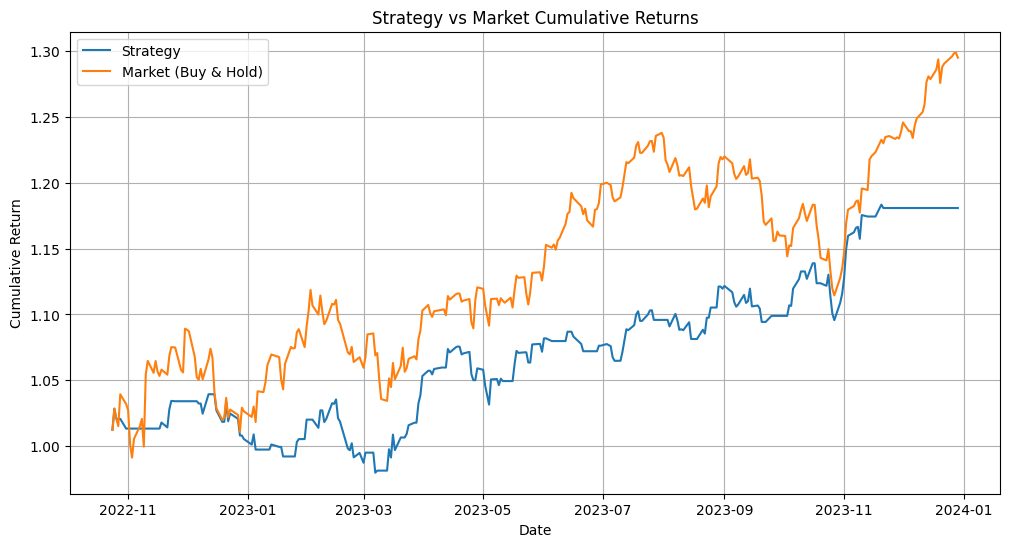

In [17]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(signals['Cumulative_Strategy_Returns'], label='Strategy')
plt.plot(signals['Cumulative_Market_Returns'], label='Market (Buy & Hold)')
plt.title('Strategy vs Market Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


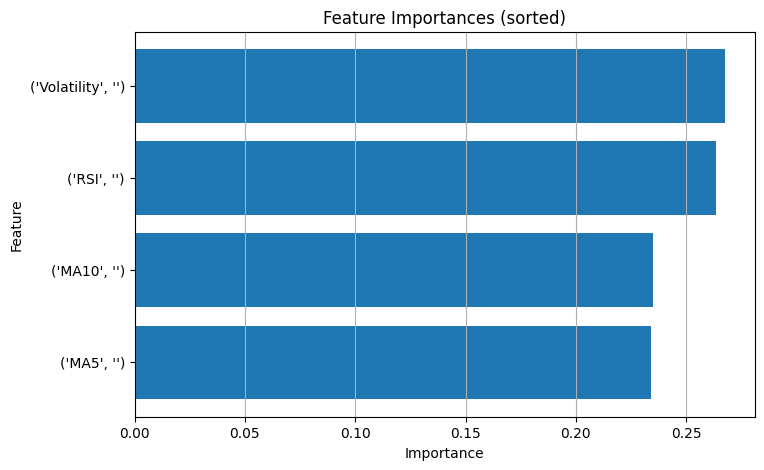

In [22]:
# Plot Feature Importances
# 1) Extract importances as a plain list of floats
importances = model.feature_importances_.tolist()

# 2) Get feature names as a plain list of strings
feature_names = list(X.columns)

# 3) Build a sorted index (from least to most important)
sorted_idx = sorted(range(len(importances)), key=lambda i: importances[i])

# 4) Reorder names & importances using that index
sorted_features    = [feature_names[i]   for i in sorted_idx]
sorted_importances = [importances[i]     for i in sorted_idx]

y_pos = np.arange(len(sorted_importances))

# 2) Plot horizontal bars at those positions
plt.figure(figsize=(8,5))
plt.barh(y_pos, sorted_importances, align='center')

# 3) Replace y-tick labels with your feature names
plt.yticks(y_pos, sorted_features)

# 4) Labels and grid
plt.title('Feature Importances (sorted)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.show()


In [25]:
import os
print("Notebook cwd:", os.getcwd())


Notebook cwd: /Users/rezapirbhai
